In [1]:
import os
import textwrap
import tiktoken
import matplotlib.pyplot as plt
import numpy as np
import umap.umap_ as umap
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from dotenv import load_dotenv, find_dotenv
from langchain.vectorstores import Chroma
from langchain.embeddings import OpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.chat_models import ChatOpenAI
from langchain.document_loaders import PyPDFLoader
from langchain.document_loaders import DirectoryLoader
from langchain import PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from typing import Optional

c:\Users\luisr\OneDrive\Documentos\GitHub\1day_1thing\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
load_dotenv(find_dotenv())
embeddings = OpenAIEmbeddings()

turbo_llm = ChatOpenAI(
    temperature=0.7,
    model_name='gpt-3.5-turbo-0125'
)

c:\Users\luisr\OneDrive\Documentos\GitHub\1day_1thing\.venv\Lib\site-packages\langchain_core\_api\deprecation.py:119: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 0.3.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import OpenAIEmbeddings`.
  warn_deprecated(
c:\Users\luisr\OneDrive\Documentos\GitHub\1day_1thing\.venv\Lib\site-packages\langchain_core\_api\deprecation.py:119: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 0.3.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import ChatOpenAI`.
  warn_deprecated(


In [3]:
# Carga de documentos y extracción de información
# (asegúrate de que haya PDFs en la carpeta documentos)
documents = DirectoryLoader('./documentos/', glob="./*.pdf", loader_cls=PyPDFLoader).load()
# Tratameinto de caracteres indeseados
for d in documents:
    d.page_content = d.page_content.replace('\n', ' ').replace('\t', ' ')
# Separador de texto (límita el texto para que sea soportado por el LLM)
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=3000,
    chunk_overlap=500
)
docs = text_splitter.split_documents(documents)
texts = [doc.page_content for doc in docs]

In [4]:
def num_tokens_from_string(string: str) -> int:
    encoding = tiktoken.get_encoding("cl100k_base")
    num_tokens = len(encoding.encode(string))
    return num_tokens

counts = [num_tokens_from_string(t) for t in texts]

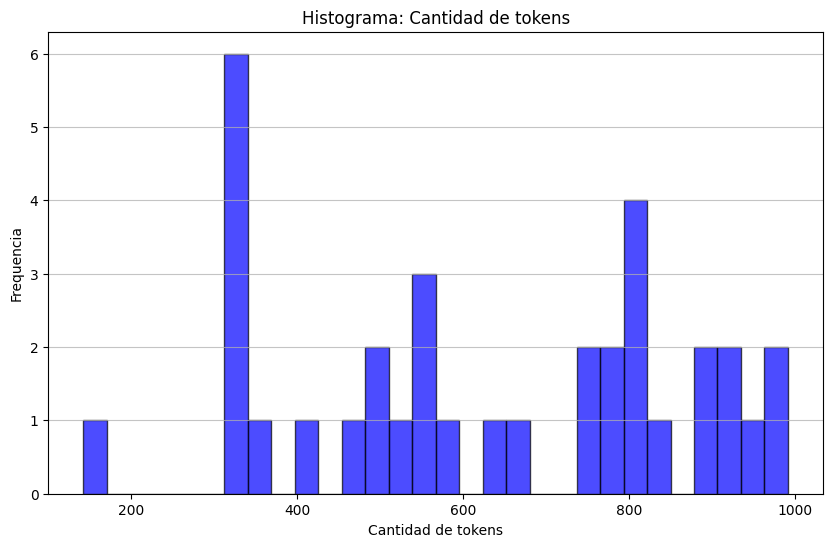

In [5]:
plt.figure(figsize=(10, 6))
plt.hist(counts, bins=30, color="blue", edgecolor="black", alpha=0.7)
plt.title("Histograma: Cantidad de tokens")
plt.xlabel("Cantidad de tokens")
plt.ylabel("Frequencia")
plt.grid(axis="y", alpha=0.75)
plt.show()

In [6]:
d_sorted = sorted(docs, key=lambda x: x.metadata["source"])
d_reversed = list(reversed(d_sorted))
concatenated_content = "\n\n\n --- \n\n\n".join(
    [doc.page_content for doc in d_reversed]
)
print(
    "Num tokens in all context: %s"
    % num_tokens_from_string(concatenated_content)
)

Num tokens in all context: 22157


In [7]:
global_embeddings = [embeddings.embed_query(txt) for txt in texts]

In [8]:
def reduce_cluster_embeddings(
    embeddings: np.ndarray,
    dim: int,
    n_neighbors: Optional[int] = None,
    metric: str = "cosine",
) -> np.ndarray:
    if n_neighbors is None:
        n_neighbors = int((len(embeddings) - 1) ** 0.5)
    return umap.UMAP(
        n_neighbors=n_neighbors, n_components=dim, metric=metric
    ).fit_transform(embeddings)

dim = 2
global_embeddings_reduced = reduce_cluster_embeddings(global_embeddings, dim)

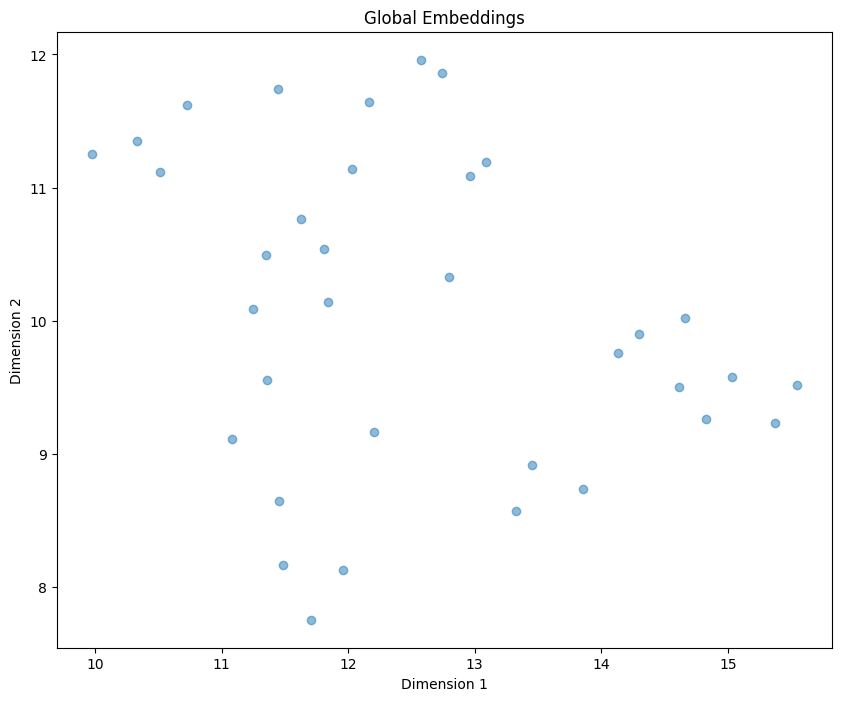

In [9]:
plt.figure(figsize=(10, 8))
plt.scatter(global_embeddings_reduced[:, 0], global_embeddings_reduced[:, 1], alpha=0.5)
plt.title("Global Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

c:\Users\luisr\OneDrive\Documentos\GitHub\1day_1thing\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\luisr\OneDrive\Documentos\GitHub\1day_1thing\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


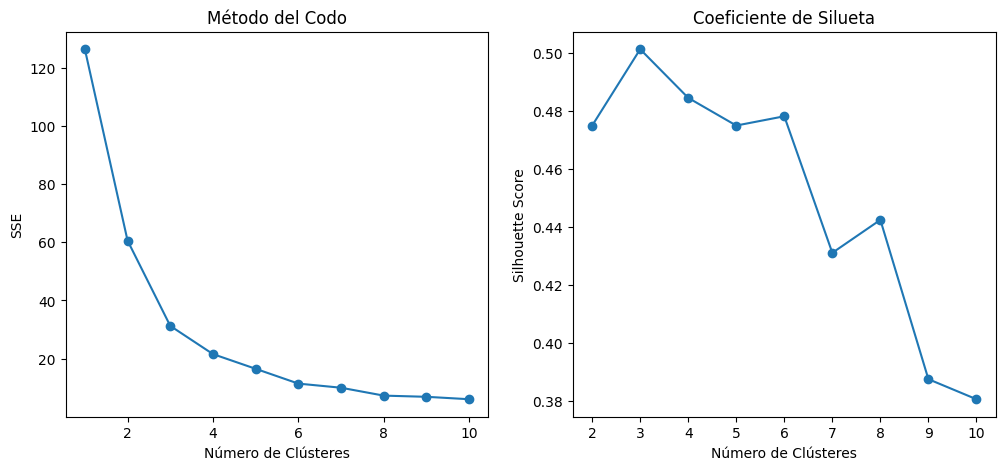

In [10]:
# Método del Codo
sse = []
k_values = range(1, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(global_embeddings_reduced)
    sse.append(kmeans.inertia_)

# Coeficiente de Silueta
silhouette_scores = []
for k in k_values[1:]:  # Silhouette score no está definido para k=1
    kmeans = KMeans(n_clusters=k, random_state=0).fit(global_embeddings_reduced)
    score = silhouette_score(global_embeddings_reduced, kmeans.labels_)
    silhouette_scores.append(score)

# Graficar el método del codo
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_values, sse, marker='o')
plt.title('Método del Codo')
plt.xlabel('Número de Clústeres')
plt.ylabel('SSE')

# Graficar el coeficiente de silueta
plt.subplot(1, 2, 2)
plt.plot(k_values[1:], silhouette_scores, marker='o')
plt.title('Coeficiente de Silueta')
plt.xlabel('Número de Clústeres')
plt.ylabel('Silhouette Score')

plt.show()

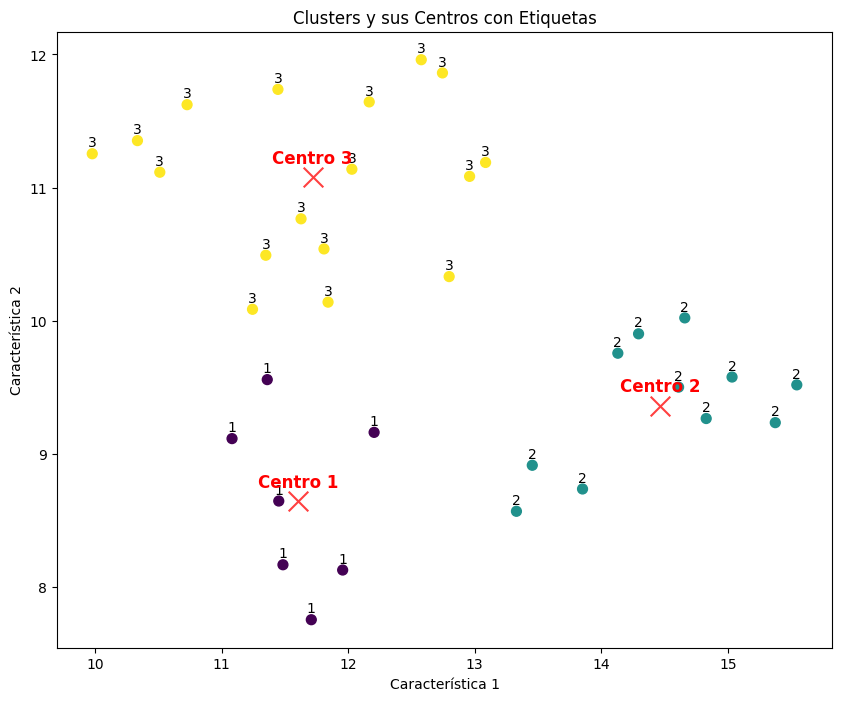

In [11]:
# Suponiendo que 'global_embeddings_reduced' ya está definido
optimal_k = 3

kmeans = KMeans(n_clusters=optimal_k, random_state=0).fit(global_embeddings_reduced)
labels = kmeans.labels_ + 1  # Agregar 1 a las etiquetas de los clústeres
centers = kmeans.cluster_centers_

# Visualizar los datos y los centros de los clústeres
plt.figure(figsize=(10, 8))
plt.scatter(global_embeddings_reduced[:, 0], global_embeddings_reduced[:, 1], c=labels, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.75, marker='x')

# Añadir etiquetas a los puntos de datos
for i in range(len(global_embeddings_reduced)):
    plt.annotate(str(labels[i]), (global_embeddings_reduced[i, 0], global_embeddings_reduced[i, 1]),
                 textcoords="offset points", xytext=(0,5), ha='center')

# Añadir etiquetas a los centros de los clústeres
for i, center in enumerate(centers):
    plt.annotate(f'Centro {i+1}', (center[0], center[1]), textcoords="offset points", xytext=(0,10), ha='center', color='red', fontsize=12, weight='bold')

plt.title("Clusters y sus Centros con Etiquetas")
plt.xlabel("Característica 1")
plt.ylabel("Característica 2")
plt.show()

In [12]:
print(len(texts))
print(len(global_embeddings_reduced))

35
35


In [13]:
df = pd.DataFrame({
    'Texto': texts,
    'Embedding': list(global_embeddings_reduced),
    'Cluster': labels
})
df.head()

,Texto,Embedding,Cluster
0,Depósito legal ppi 201502ZU4662 Esta publicaci...,"[12.7450695, 11.860949]",3
1,Disponible en: https://produccioncientificaluz...,"[11.956897, 8.128976]",1
2,108Licencia de Creative Commons Atribución 4....,"[11.485205, 8.168594]",1
3,"la obtención de ganancias, siendo una condici...","[12.9594755, 11.08433]",3
4,"109 Revista de Ciencias Sociales, Vol. XXIX, N...","[13.0857525, 11.188825]",3


In [14]:
def format_cluster_texts(df):
    clustered_texts = {}
    for cluster in df['Cluster'].unique():
        cluster_texts = df[df['Cluster'] == cluster]['Texto'].tolist()
        clustered_texts[cluster] = " --- ".join(cluster_texts)
    return clustered_texts

clustered_texts = format_cluster_texts(df)
clustered_texts

{3: 'Depósito legal ppi 201502ZU4662 Esta publicación científica en formato digital es continuidad de la revista impresa Depósito Legal: pp 197402ZU789 ● ISSN: 1315-9518 ● ISSN-E: 2477-9431 Esta publicación científica en formato digital es continuidad de la revista impresa Depósito Legal: pp 197402ZU789 ISSN: 1315-9518Universidad del Zulia. Revista de la Facultad de Ciencias Económicas y Sociales Vol. XXIX, No. 4                                                    OCTUBRE-DICIEMBRE 2023 --- la obtención de ganancias, siendo  una condición tecnológica inherente a todos  los problemas de eficiencia y eficacia (Caird,  1992; Campo-Ternera et al., 2018; Velázquez, Cruz y Vargas, 2018; Vega, Bautista y  Martínez, 2020; Medina y Espinosa, 2022).  Por su parte, Albornoz (2009), lo describe  como la búsqueda de mejores condiciones  competitivas desde las empresas a través de  la investigación básica y la tecnología. Es así  que la innovación se compone de una serie  de actividades, no solamente

# Hay que volver a hacer un split de texto para solucionar problemas de capacidad en el LLM.

In [15]:
template = """Eres un asistente capaz de crear resumenes detallados y concisos del texto proporcionado.

Texto:
{text}
"""

prompt = PromptTemplate.from_template(template)
chain = prompt | turbo_llm | StrOutputParser()

In [16]:
summaries = {}
for cluster, text in clustered_texts.items():
    summary = chain.invoke({"text": text})
    summaries[cluster] = summary

summaries

{3: 'Este texto detalla la importancia de la innovación en las pequeñas y medianas empresas (pyme) a nivel global. Se menciona que la innovación es esencial para la eficiencia y eficacia de las empresas, y se destaca la importancia de la investigación y la tecnología en este proceso. Se menciona que la innovación no solo se refiere a aspectos científicos y tecnológicos, sino también a aspectos organizacionales, financieros y comerciales.\n\nSe analiza el papel de las redes sociales en la innovación, así como la relevancia de la gestión del riesgo, la sustentabilidad y el rendimiento en las pyme. Se identifican estudios que relacionan la innovación con el desempeño, el empleo y el desarrollo de ventajas competitivas en diferentes sectores económicos a nivel mundial.\n\nTambién se menciona la importancia de la innovación incremental en el desempeño de las empresas, así como la necesidad de mejorar los procesos de innovación en el mercado, productos y procesos. Se destaca la relevancia de

In [17]:
clustered_summaries = {}
for label, summary in zip(labels, summaries.values()):
    if label not in clustered_summaries:
        clustered_summaries[label] = []
    clustered_summaries[label].append(summary)

clustered_summaries

{3: ['Este texto detalla la importancia de la innovación en las pequeñas y medianas empresas (pyme) a nivel global. Se menciona que la innovación es esencial para la eficiencia y eficacia de las empresas, y se destaca la importancia de la investigación y la tecnología en este proceso. Se menciona que la innovación no solo se refiere a aspectos científicos y tecnológicos, sino también a aspectos organizacionales, financieros y comerciales.\n\nSe analiza el papel de las redes sociales en la innovación, así como la relevancia de la gestión del riesgo, la sustentabilidad y el rendimiento en las pyme. Se identifican estudios que relacionan la innovación con el desempeño, el empleo y el desarrollo de ventajas competitivas en diferentes sectores económicos a nivel mundial.\n\nTambién se menciona la importancia de la innovación incremental en el desempeño de las empresas, así como la necesidad de mejorar los procesos de innovación en el mercado, productos y procesos. Se destaca la relevancia d

In [18]:
final_summaries = {}
for cluster, texts in clustered_summaries.items():
    combined_text = ' '.join(texts)
    summary = chain.invoke({"text": combined_text})
    final_summaries[cluster] = summary

final_summaries

{3: 'El texto resalta la importancia de la innovación en las pequeñas y medianas empresas (pyme) a nivel global, mencionando que es esencial para la eficiencia y eficacia de las empresas. Se destaca la relevancia de la investigación, la tecnología y la gestión del riesgo en este proceso, así como la importancia de la innovación en aspectos organizacionales, financieros y comerciales. Se identifican estudios que relacionan la innovación con el desempeño, el empleo y el desarrollo de ventajas competitivas en diferentes sectores económicos a nivel mundial. Se destaca la importancia de la innovación incremental y de mejorar los procesos de innovación en el mercado, productos y procesos. Además, se analiza el papel de las tecnologías de información y comunicación (TIC) en los procesos de innovación en las pyme y se mencionan las metodologías utilizadas, como técnicas cuantitativas. También se mencionan las limitaciones del estudio y se resalta la importancia de analizar las tendencias actua

In [19]:
texts_from_df = df['Texto'].tolist()
texts_from_clustered_texts = list(clustered_texts.values())
texts_from_final_summaries = list(final_summaries.values())

combined_texts = texts_from_df + texts_from_clustered_texts + texts_from_final_summaries

### 1. Enseñar

In [26]:
persist_directory = input('¿Cómo se llama este knoledge-base?: ') + '_kb'
vectorstore = Chroma.from_texts(texts=combined_texts,
                                embedding=embeddings,
                                persist_directory=persist_directory)
vectorstore.persist()
vectorstore = None
os.system(f'zip -r db.zip ./{persist_directory}')

1

### 2. Recordar (si y solo si Enseñar=Done) y pregunta de control

In [ ]:
persist_directory = input('¿Qué knoledge-base deseas usar?: ')
persist_directory = './kbs/' + persist_directory + '_kb'
embedding = OpenAIEmbeddings()
vectorstore = Chroma(persist_directory=persist_directory, 
                  embedding_function=embedding)

def adjust_final_number(string: str, max_threshold: int, initial_number: int) -> int:
    final_number = initial_number
    while final_number < max_threshold:
        retriever = vectorstore.as_retriever(search_kwargs={"k": final_number})
        docs = retriever.get_relevant_documents(string)
        text = "".join([doc.page_content for doc in docs])
        if num_tokens_from_string(text) < max_threshold:
            final_number += 1
        else:
            break
    return final_number

final_number = adjust_final_number("¿Cuál es el tema pricipal del documento?", 10000, 4)
print(final_number)
retriever = vectorstore.as_retriever(search_kwargs={"k": final_number})

In [ ]:
# Se personaliza el LLM
template = """
Eres Prometeo, un asistente personal de lectura que habla Español.

Tu tarea consiste en:

1. Ser carismático y ofrecer información sobre ti y tus funciones.

2. Leer detalladamente la información proporcionada en documentos
de texto en formato PDF, para ser capaz de dar respuestas a cualquier tipo de pregunta,
en especial a preguntas puntuales.

SIEMPRE debes responder con base al contexto proporcionado aqui: {context}.
        
Si no sabes la respuesta, puedes decir: 'No sé'.

NUNCA hables del contexto.

Teniendo lo anterior en cuenta, responde la siguiente pregunta: {question}
"""

prometeo_prompt = PromptTemplate(
    template=template, input_variables=["context", "question"]
)

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prometeo_prompt
    | turbo_llm
    | StrOutputParser()
)

In [ ]:
# Demo
query = input("Hazme una pregunta: ")
print(query)
llm_response = rag_chain.invoke(query)
wrapper = textwrap.TextWrapper(width=70) 
word_list = wrapper.wrap(text=llm_response) 

# Print each line. 
for element in word_list: 
    print(element)

In [ ]:
# Demo
query = input("Hazme una pregunta: ")
print(query)
llm_response = rag_chain.invoke(query)
wrapper = textwrap.TextWrapper(width=70) 
word_list = wrapper.wrap(text=llm_response) 

# Print each line. 
for element in word_list: 
    print(element)

In [ ]:
# Demo
query = input("Hazme una pregunta: ")
print(query)
llm_response = rag_chain.invoke(query)
wrapper = textwrap.TextWrapper(width=70) 
word_list = wrapper.wrap(text=llm_response) 

# Print each line. 
for element in word_list: 
    print(element)

In [ ]:
# Demo
query = input("Hazme una pregunta: ")
print(query)
llm_response = rag_chain.invoke(query)
wrapper = textwrap.TextWrapper(width=70) 
word_list = wrapper.wrap(text=llm_response) 

# Print each line. 
for element in word_list: 
    print(element)

In [ ]:
# Demo
query = input("Hazme una pregunta: ")
print(query)
llm_response = rag_chain.invoke(query)
wrapper = textwrap.TextWrapper(width=70) 
word_list = wrapper.wrap(text=llm_response) 

# Print each line. 
for element in word_list: 
    print(element)

### 2. Recordar (si y solo si Enseñar=Done)

In [ ]:
# Now we can load the persisted database from disk, and use it as normal. 
persist_directory = input('¿Qué knoledge-base deseas usar?: ') + '_kb'
embedding = OpenAIEmbeddings()
vectordb = Chroma(persist_directory=persist_directory, 
                  embedding_function=embedding)
retriever = vectordb.as_retriever(search_kwargs={"k": 5})
#retriever = vectordb.as_retriever()